<a href="https://colab.research.google.com/github/jacob-m-nash/Fire-Detector/blob/main/src/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FireNet YOLOv5 custom data set training

Adapted from https://blog.paperspace.com/train-yolov5-custom-data/#convert-the-annotations-into-the-yolo-v5-format

## Set up for YOLO training

In [1]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15647, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 15647 (delta 130), reused 175 (delta 101), pack-reused 15393
Receiving objects: 100% (15647/15647), 14.59 MiB | 13.29 MiB/s, done.
Resolving deltas: 100% (10659/10659), done.


Note torch has been removed from requirements.txt  

In [2]:
!pip install -r yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.5 MB/s eta 0:00:00


In [3]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import distutils.dir_util
import yaml
import csv
from google.colab import files

random.seed(108)

## Setup file paths 

In [4]:
base_path = os.getcwd()
data_filename = "FireNet.zip"
annotations_path = os.path.join(base_path,"FireNet_ObjectDetection")
images_path = os.path.join(base_path,"FireNet_Images")

## Donload and unzip data

In [5]:
!wget --content-disposition -nc https://rdr.ucl.ac.uk/ndownloader/articles/9137798/versions/1 -O "$data_filename"
!unzip "$data_filename"
!unzip -q /content/FireNet_Images.zip  -d  "$images_path"
!unzip -q /content/FireNet_ObjectDetection.zip -d  "$annotations_path"

--2023-05-11 15:06:19--  https://rdr.ucl.ac.uk/ndownloader/articles/9137798/versions/1
Resolving rdr.ucl.ac.uk (rdr.ucl.ac.uk)... 52.215.33.185, 54.72.116.230, 2a05:d018:1f4:d003:fcf0:3aeb:80fc:a5ef, ...
Connecting to rdr.ucl.ac.uk (rdr.ucl.ac.uk)|52.215.33.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2821306495 (2.6G) [application/zip]
Saving to: ‘FireNet.zip’

FireNet.zip         100%[===================>]   2.63G  33.9MB/s    in 82s     

2023-05-11 15:07:42 (32.9 MB/s) - ‘FireNet.zip’ saved [2821306495/2821306495]

Archive:  FireNet.zip
 extracting: FireNet_Images.zip      
 extracting: FireNet_ObjectDetection.zip  
 extracting: FireNet_SemanticSegmentation.zip  
 extracting: FireNet_labels.csv      


## Convert the Annotations into the YOLO v5 Format

In [6]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [7]:
example_xml_file = os.path.join(annotations_path, "0000.xml")
print(extract_info_from_xml(example_xml_file))

{'bboxes': [{'class': 'Fire_Extinguisher', 'xmin': 265, 'ymin': 1018, 'xmax': 761, 'ymax': 1950}, {'class': 'Fire_Suppression_Signage', 'xmin': 495, 'ymin': 773, 'xmax': 692, 'ymax': 958}], 'filename': '0000.jpg', 'image_size': (1536, 2048, 3)}


In [8]:
labels_file = os.path.join(base_path, "FireNet_labels.csv")
with open(labels_file, mode='r') as in_file:
    reader = csv.reader(in_file)
    next(reader) # Skipping header 
    class_name_to_id_mapping = {rows[1]:(int(rows[0])-1) for rows in reader}
print(class_name_to_id_mapping)

{'Alarm_Activator': 0, 'Fire_Blanket': 1, 'Fire_Exit': 2, 'Fire_Extinguisher': 3, 'Fire_Suppression_Signage': 4, 'Flashing_Light_Orbs': 5, 'Sounders': 6, 'White_Domes': 7}


In [9]:
# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
            if(class_id == 8):
                print("oh no")
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
    
    # Name of the file which we have to save 
    save_file_name = os.path.join(annotations_path, info_dict["filename"].replace("jpg", "txt"))
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [10]:
# Get the annotations
annotations = [os.path.join(annotations_path, x) for x in os.listdir(annotations_path) if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join(annotations_path, x) for x in os.listdir(annotations_path) if x[-3:] == "txt"]

100%|██████████| 1452/1452 [00:00<00:00, 8334.17it/s]


In [11]:
def plot_bounding_box(image, annotation_list,class_id_to_name_mapping):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)),outline ="green")
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[obj_cls],fill="green")
    
    plt.imshow(np.array(image))
    plt.show()


### Testing the annotations

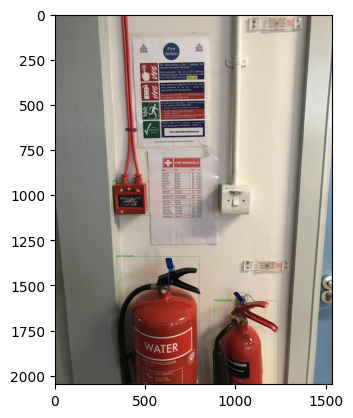

In [12]:
random.seed(32)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))
# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]


#Get the corresponding image file
image_file = annotation_file.replace("FireNet_ObjectDetection", "FireNet_Images").replace("txt", "jpg")
assert os.path.exists(image_file)
#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list,class_id_to_name_mapping)

## Partition the Dataset

In [13]:
# Read images and annotations
images = [os.path.join(images_path, x) for x in os.listdir(images_path)]
annotations = [os.path.join(annotations_path, x) for x in os.listdir(annotations_path) if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [14]:
#Utility function to copy images 
def copy_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.copy(f, destination_folder)
        except:
            print(f)
            assert False

In [15]:
# Copy the splits into their folders
images_folder = os.path.join(base_path, "images")
labels_folder = os.path.join(base_path, "labels")

train_iamges_folder = os.path.join(images_folder, "train")
os.makedirs(train_iamges_folder, exist_ok=True)
os.chmod(train_iamges_folder,0o777)
copy_files_to_folder(train_images, train_iamges_folder)

val_images_folder = os.path.join(images_folder, "val")
os.makedirs(val_images_folder, exist_ok=True)
os.chmod(val_images_folder,0o777)
copy_files_to_folder(val_images, val_images_folder)

test_images_folder = os.path.join(images_folder, "test")
os.makedirs(test_images_folder, exist_ok=True)
os.chmod(test_images_folder,0o777)
copy_files_to_folder(test_images, test_images_folder)

train_labels_folder = os.path.join(labels_folder, "train")
os.makedirs(train_labels_folder, exist_ok=True)
os.chmod(train_labels_folder,0o777)
copy_files_to_folder(train_annotations, train_labels_folder)

val_labels_folder = os.path.join(labels_folder, "val")
os.makedirs(val_labels_folder, exist_ok=True)
os.chmod(val_labels_folder,0o777)
copy_files_to_folder(val_annotations, val_labels_folder)

test_labels_folder = os.path.join(labels_folder, "test")
os.makedirs(test_labels_folder, exist_ok=True)
os.chmod(test_labels_folder,0o777)
copy_files_to_folder(test_annotations, test_labels_folder)


## Create and Copy Config File 

In [16]:
config_file_dict = {"train":"../.." + train_iamges_folder + "/", "val":"../.." + val_images_folder + "/", "test":"../.." + test_images_folder + "/", "nc":len(class_name_to_id_mapping), "names":list(class_name_to_id_mapping.keys())}
with open('Fire_Detector.yaml', 'w') as outfile:
  yaml_string=yaml.dump(config_file_dict, outfile)

In [17]:
shutil.copy("Fire_Detector.yaml", "yolov5/data") 

'yolov5/data/Fire_Detector.yaml'

## Train the Model

In [ ]:
!python yolov5/train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch-low.yaml --batch 16 --epochs 100 --data Fire_Detector.yaml --weights yolov5s.pt --workers 24 --name yolo_fire_detector

      14/99         0G    0.03319    0.01424   0.005217         18        640: 100% 73/73 [21:07<00:00, 17.36s/it]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 5/5 [00:39<00:00,  7.93s/it]
                   all        145        228      0.881      0.772      0.905      0.591

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      15/99         0G     0.0327      0.014   0.005178         24        640: 100% 73/73 [21:10<00:00, 17.40s/it]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 5/5 [00:40<00:00,  8.04s/it]
                   all        145        228      0.851       0.81      0.898      0.553

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      16/99         0G    0.03303    0.01391   0.004525         31        640: 100% 73/73 [21:16<00:00, 17.48s/it]
                 Class     Images  Instances          P          R     

## Copy Run Uutput and Save

In [19]:
# Taken from https://stackoverflow.com/questions/57751402/increment-directory-name-if-it-already-exists
def generateDirectoryName(name, x=0):
    dir_name = (name + (' ' + str(x) if x is not 0 else '')).strip()
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        return dir_name
    else:
        return generateDirectoryName(name, x + 1)
run_folder = os.path.join(base_path, "runs/yolov5_fire_detector")

run_dest_folder = generateDirectoryName(run_folder)
distutils.dir_util.copy_tree("yolov5/runs/train/yolo_fire_detector", run_dest_folder)
run_folder_zip_file = run_dest_folder + ".zip"
!zip -r "$run_folder_zip_file" "$run_dest_folder"
files.download(run_folder_zip_file)